In [61]:
import numpy as np

class Grid:
    """Class defining a one-dimensional Cartesian grid"""

    def __init__(self, lx, ly, lz, ncv):
        """Constructor
            lx .... total length of domain in x-direction [m]
            ly .... total length of domain in x-direction [m]
            lz .... total length of domain in x-direction [m]
            ncv ... number of control volumes in domain
        """
        # Store the number of control volumes
        self._ncv = ncv

        # Calculate the control volume length
        dx = lx/float(ncv)

        # Calculate the face locations
        self._xf = np.array([i*dx for i in range(ncv+1)])

        # Calculate the cell centroid locations
        self._xP = np.array([self._xf[0]] +
                            [0.5*(self._xf[i]+self._xf[i+1]) for i in range(ncv)] +
                            [self._xf[-1]])

        # Calculate face areas
        self._Af = ly*lz*np.ones(ncv+1)

        # Calculate the outer surface area for each cell
        self._Ao = (2.0*dx*ly + 2.0*dx*lz)*np.ones(ncv)

        # Calculate cell volumes
        self._vol = dx*ly*lz*np.ones(ncv)

    @property
    def ncv(self):
        """Number of control volumes in domain"""
        return self._ncv

    @property
    def xf(self):
        """Face location array"""
        return self._xf

    @property
    def xP(self):
        """Cell centroid array"""
        return self._xP

    @property
    def dx_WP(self):
        return self.xP[1:-1]-self.xP[0:-2]

    @property
    def dx_PE(self):
        return self.xP[2:]-self.xP[1:-1]

    @property
    def Af(self):
        """Face area array"""
        return self._Af

    @property
    def Aw(self):
        """West face area array"""
        return self._Af[0:-1]

    @property
    def Ae(self):
        """East face area array"""
        return self._Af[1:]

    @property
    def Ao(self):
        """Outer face area array"""
        return self._Ao

    @property
    def vol(self):
        """Cell volume array"""
        return self._vol


In [62]:
import numpy as np

class ScalarCoeffs:
    """Class defining the set of coefficients for a finite-volume discretization
       of a scalar partial differential equation.
    """

    def __init__(self, ncv):
        """Constructor
            ncv ... number of control volumes in domain
        """
        self._ncv = ncv
        self._aP = np.zeros(ncv)
        self._aW = np.zeros(ncv)
        self._aE = np.zeros(ncv)
        self._rP = np.zeros(ncv)

    def zero(self):
        """Function to zero the coefficient arrays"""
        self._aP.fill(0.0)
        self._aW.fill(0.0)
        self._aE.fill(0.0)
        self._rP.fill(0.0)

    def accumulate_aP(self, aP):
        """Function to accumulate values onto aP"""
        self._aP += aP

    def accumulate_aW(self, aW):
        """Function to accumulate values onto aW"""
        self._aW += aW

    def accumulate_aE(self, aE):
        """Function to accumulate values onto aE"""
        self._aE += aE

    def accumulate_rP(self, rP):
        """Function to accumulate values onto rP"""
        self._rP += rP

    @property
    def ncv(self):
        """Number of control volumes in domain"""
        return self._ncv

    @property
    def aP(self):
        """Cell coefficient"""
        return self._aP

    @property
    def aW(self):
        """West cell coefficient"""
        return self._aW

    @property
    def aE(self):
        """East cell coefficient"""
        return self._aE

    @property
    def rP(self):
        """Cell residual"""
        return self._rP


In [63]:
from enum import Enum

class BoundaryLocation(Enum):
    """Enumeration class defining boundary condition locations"""
    WEST = 1
    EAST = 2

class DirichletBc:
    """Class defining a Dirichlet boundary condition"""

    def __init__(self, phi, grid, value, loc):
        """Constructor
            phi ..... field variable array
            grid .... grid
            value ... boundary value
            loc ..... boundary location
        """
        self._phi = phi
        self._grid = grid
        self._value = value
        self._loc = loc

    def value(self):
        """Return the boundary condition value"""
        return self._value

    def coeff(self):
        """Return the linearization coefficient"""
        return 0

    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = self._value
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = self._value
        else:
            raise ValueError("Unknown boundary location")

class NeumannBc:
    """Class defining a Neumann boundary condition"""

    def __init__(self, phi, grid, gradient, loc):
        """Constructor
            phi ........ field variable array
            grid ....... grid
            gradient ... gradient at cell adjacent to boundary
            loc ........ boundary location
        """
        self._phi = phi
        self._grid = grid
        self._gradient = gradient
        self._loc = loc

    def value(self):
        """Return the boundary condition value"""
        if self._loc is BoundaryLocation.WEST:
            return self._phi[1] - self._gradient*self._grid.dx_WP[0]
        elif self._loc is BoundaryLocation.EAST:
            return self._phi[-2] + self._gradient*self._grid.dx_PE[-1]
        else:
            raise ValueError("Unknown boundary location")

    def coeff(self):
        """Return the linearization coefficient"""
        return 1

    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = self._phi[1] - self._gradient*self._grid.dx_WP[0]
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = self._phi[-2] + self._gradient*self._grid.dx_PE[-1]
        else:
            raise ValueError("Unknown boundary location")


In [64]:
class DiffusionModel:
    """Class defining a diffusion model"""

    def __init__(self, grid, phi, gamma, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._gamma = gamma
        self._west_bc = west_bc
        self._east_bc = east_bc

    def add(self, coeffs):
        """Function to add diffusion terms to coefficient arrays"""

        # Calculate the west and east face diffusion flux terms for each face
        flux_w = - self._gamma*self._grid.Aw*(self._phi[1:-1]-self._phi[0:-2])/self._grid.dx_WP
        flux_e = - self._gamma*self._grid.Ae*(self._phi[2:]-self._phi[1:-1])/self._grid.dx_PE

        # Calculate the linearization coefficients
        coeffW = - self._gamma*self._grid.Aw/self._grid.dx_WP
        coeffE = - self._gamma*self._grid.Ae/self._grid.dx_PE
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)

        # Return the modified coefficient array
        return coeffs

class SurfaceConvectionModel:
    """Class defining a surface convection model"""

    def __init__(self, grid, T, ho, To):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._ho = ho
        self._To = To

    def add(self, coeffs):
        """Function to add surface convection terms to coefficient arrays"""

        # Calculate the source term
        source = self._ho*self._grid.Ao*(self._T[1:-1] - self._To)

        # Calculate the linearization coefficients
        coeffP = self._ho*self._grid.Ao

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(source)

        return coeffs

class FirstOrderTransientModel:
    """Class defining a first order implicit transient model"""

    def __init__(self, grid, T, Told, rho, cp, dt):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._Told = Told
        self._rho = rho
        self._cp = cp
        self._dt = dt

    def add(self, coeffs):
        """Function to add transient term to coefficient arrays"""

        # Calculate the transient term
        transient = self._rho*self._cp*self._grid.vol*(self._T[1:-1]-self._Told[1:-1])/self._dt

        # Calculate the linearization coefficient
        coeff = self._rho*self._cp*self._grid.vol/self._dt

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeff)
        coeffs.accumulate_rP(transient)

        return coeffs


In [65]:
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix

def get_sparse_matrix(coeffs):
    """Function to return a sparse matrix representation of a set of scalar coefficients"""
    ncv = coeffs.ncv
    data = np.zeros(3*ncv-2)
    rows = np.zeros(3*ncv-2, dtype=int)
    cols = np.zeros(3*ncv-2, dtype=int)
    data[0] = coeffs.aP[0]
    data[1] = coeffs.aE[0]
    rows[0] = 0
    cols[0] = 0
    rows[1] = 0
    cols[1] = 1
    for i in range(ncv-2):
        data[3*i+2] = coeffs.aW[i+1]
        data[3*i+3] = coeffs.aP[i+1]
        data[3*i+4] = coeffs.aE[i+1]
        rows[3*i+2:3*i+5] = i+1
        cols[3*i+2] = i
        cols[3*i+3] = i+1
        cols[3*i+4] = i+2
    data[3*ncv-4] = coeffs.aW[-1]
    data[3*ncv-3] = coeffs.aP[-1]
    rows[3*ncv-4:3*ncv-2] = ncv-1
    cols[3*ncv-4] = ncv-2
    cols[3*ncv-3] = ncv-1
    return csr_matrix((data, (rows, cols)))

def solve(coeffs):
    """Function to solve the linear system and return the correction field"""
    # Get the sparse matrix
    A = get_sparse_matrix(coeffs)
    # Solve the linear system
    return spsolve(A, -coeffs.rP)


# <center><font color=|blue|>UDS Scheme </font></center>

In [66]:
import numpy as np

class UpwindAdvectionModel:
    """Class defining an upwind advection model"""

    def __init__(self, grid, phi, Uhe, rho, cp, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._cp = cp
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)

    def add(self, coeffs):
        """Function to add diffusion terms to coefficient arrays"""

        # Calculate the weighting factors
        self._alphae[0]=1
        for i in range(1,self._grid.ncv):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
            else:
                self._alphae[i] = -1
        self._alphae[self._grid.ncv]=-1
        
        # Calculate the east integration point values (including both boundaries)

        self._phie = (1 + self._alphae)/2*self._phi[0:-1] + (1 - self._alphae)/2*self._phi[1:]
               
        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face
        flux_w = self._cp*mdote[:-1]*self._phie[:-1]
        flux_e = self._cp*mdote[1:]*self._phie[1:]
        
        # Calculate mass imbalance term
        imbalance = - self._cp*mdote[1:]*self._phi[1:-1] + self._cp*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._cp*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._cp*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)

        # Return the modified coefficient array
        return coeffs

In [67]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 5.0
ly = 0.01
lz = 0.01
ncv = 5
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 1
dt = 1e10
time = 0

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1000
cp  = 4189
k   = 0.590

# Define the surface convection parameters
ho = 10000
To = 100

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 0
U0 = -1.5

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)
Uhe = U0*np.ones(grid.ncv+1)

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Define the transient model
Told = np.copy(T)
#transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Define the advection model
advection = UpwindAdvectionModel(grid, T, Uhe, rho, cp, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = surfaceConvection.add(coeffs)
        coeffs = advection.add(coeffs)
        #coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()


Timestep = 0; Time = 10000000000.0
Iteration = 0; Max. Resid. = 40000.0; Avg. Resid. = 40000.0
Iteration = 1; Max. Resid. = 7.275957614183426e-12; Avg. Resid. = 5.638867150992155e-12


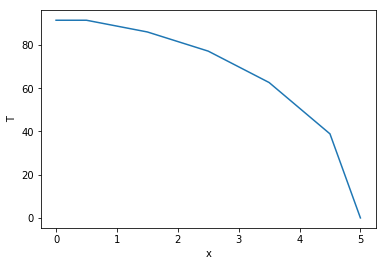

[91.48267162 91.48267162 86.06064404 77.18701918 62.6645524  38.89725951
  0.        ]


In [68]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(grid.xP, T)
TUDS = T
plt.xlabel("x")
plt.ylabel("T")
plt.show()
print(T)

# <center><font color=|blue|>CDS Scheme </font></center>

In [69]:
import numpy as np

class CentralAdvectionModel:
    """Class defining an Central advection model"""

    def __init__(self, grid, phi, Uhe, rho, cp, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._cp = cp
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)

    def add(self, coeffs):
        """Function to add diffusion terms to coefficient arrays"""

        # Calculate the weighting factors
        self._alphae[0]=1 # Is it correct??????????????????? Note:It is used to det. T at boundaries
        for i in range(1,self._grid.ncv):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
            else:
                self._alphae[i] = -1
        self._alphae[self._grid.ncv]=-1
        
        # Calculate the east integration point values and values at boundaries
        # Is the following appropriate in defining Te for cells & boundaries??????????????????????????
        
        # For cells
        for i in range(1,self._grid.ncv):
            self._phie[i] = (1/2)*self._phi[i] + (1/2)*self._phi[i+1]
            
        # For boundaries
        # At the left boundary 
        self._phie[0] = ((1 + self._alphae[0])/2)*self._phi[0] + ((1 - self._alphae[0])/2)*self._phi[-1]
        # At the right boundary
        self._phie[-1] = ((1 + self._alphae[self._grid.ncv])/2)*self._phi[0] + ((1 - self._alphae[self._grid.ncv])/2)*self._phi[-1]
        
        
        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face
        flux_w = self._cp*mdote[:-1]*self._phie[:-1]
        flux_e = self._cp*mdote[1:]*self._phie[1:]
        
        # Calculate mass imbalance term
        imbalance = - self._cp*mdote[1:]*self._phi[1:-1] + self._cp*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._cp*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._cp*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)

        # Return the modified coefficient array
        return coeffs

In [70]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 5.0
ly = 0.01
lz = 0.01
ncv = 5
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 1
dt = 1e10
time = 0

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1000
cp  = 4189
k   = 0.590

# Define the surface convection parameters
ho = 10000 #???????????????????????????????????????????????????????????
To = 100 #????????????????????????????????????????????

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 0
U0 = -1.5

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)
Uhe = U0*np.ones(grid.ncv+1)

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Define the transient model
Told = np.copy(T)
#transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Define the advection model
advection = CentralAdvectionModel(grid, T, Uhe, rho, cp, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = surfaceConvection.add(coeffs)
        coeffs = advection.add(coeffs)
        #coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()


Timestep = 0; Time = 10000000000.0
Iteration = 0; Max. Resid. = 40000.0; Avg. Resid. = 40000.0
Iteration = 1; Max. Resid. = 7467.08924645244; Avg. Resid. = 2986.835698580982
Iteration = 2; Max. Resid. = 1774.724701146959; Avg. Resid. = 748.0769463378199
Iteration = 3; Max. Resid. = 527.2549491965874; Avg. Resid. = 276.86347271720444
Iteration = 4; Max. Resid. = 175.43990304372346; Avg. Resid. = 112.97284620812025
Iteration = 5; Max. Resid. = 96.9109277934167; Avg. Resid. = 45.318183242067064
Iteration = 6; Max. Resid. = 60.576608027344264; Avg. Resid. = 25.832994445905843
Iteration = 7; Max. Resid. = 36.820903837016886; Avg. Resid. = 18.032907285755936
Iteration = 8; Max. Resid. = 23.563683609711006; Avg. Resid. = 12.90859854897426
Iteration = 9; Max. Resid. = 17.116872378699554; Avg. Resid. = 8.648909041395473


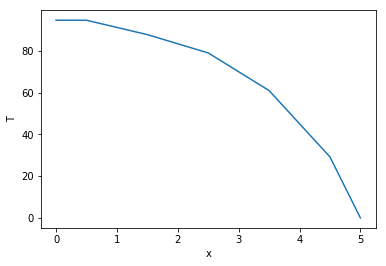

[94.5965859  94.5965859  87.71806887 78.95212301 60.94381808 29.18998365
  0.        ]


In [71]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(grid.xP, T)
TCDS = T
plt.xlabel("x")
plt.ylabel("T")
plt.show()
print(T)

# <center><font color=|blue|>QUICK Scheme </font></center>

In [72]:
import numpy as np

class QUICKAdvectionModel:
    """Class defining an Central advection model"""

    def __init__(self, grid, phi, Uhe, rho, cp, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._cp = cp
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)

    def add(self, coeffs):
        """Function to add diffusion terms to coefficient arrays"""

        # Calculate the weighting factors
        self._alphae[0]=1 # Is it correct??????????????????? Note:It is used to det. T at boundaries
        for i in range(1,self._grid.ncv):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
            else:
                self._alphae[i] = -1
        self._alphae[self._grid.ncv]=-1
        
        # Calculate the east integration point values and values at boundaries
        # Is the following appropriate in defining Te for cells & boundaries??????????????????????????
        
        # For cells
        for i in range (1,self._grid.ncv): #??????????????????????????????????
            if self._Uhe[i] < 0:
            # for flow in negative direction
                s = ((grid.xf[i] - grid.xP[i+1])*(grid.xf[i] - grid.xP[i]))/((grid.xP[i+2] - grid.xP[i+1])*(grid.xP[i+2] - grid.xP[i]))
                t = ((grid.xf[i] - grid.xP[i+2])*(grid.xf[i] - grid.xP[i]))/((grid.xP[i+1] - grid.xP[i+2])*(grid.xP[i+1] - grid.xP[i]))
                u = ((grid.xf[i] - grid.xP[i+1])*(grid.xf[i] - grid.xP[i+2]))/((grid.xP[i] - grid.xP[i+1])*(grid.xP[i] - grid.xP[i+2]))
                self._phie[i] = s*self._phi[i+2] + t*self._phi[i+1] + u*self._phi[i]
             
            else:
                # for flow in positive direction
                p = ((grid.xf[i] - grid.xP[i])*(grid.xf[i] - grid.xP[i+1]))/((grid.xP[i-1] - grid.xP[i])*(grid.xP[i-1] - grid.xP[i+1]))
                q = ((grid.xf[i] - grid.xP[i-1])*(grid.xf[i] - grid.xP[i+1]))/((grid.xP[i] - grid.xP[i-1])*(grid.xP[i] - grid.xP[i+1]))
                r = ((grid.xf[i] - grid.xP[i-1])*(grid.xf[i] - grid.xP[i]))/((grid.xP[i+1] - grid.xP[i-1])*(grid.xP[i+1] - grid.xP[i]))
                self._phie[i] = p*self._phi[i-1] + q*self._phi[i] + r*self._phi[i+1]      
        
        # For boundaries
        # At the left boundary 
        self._phie[0] = ((1 + self._alphae[0])/2)*self._phi[0] + ((1 - self._alphae[0])/2)*self._phi[-1]
        # At the right boundary
        self._phie[-1] = ((1 + self._alphae[self._grid.ncv])/2)*self._phi[0] + ((1 - self._alphae[self._grid.ncv])/2)*self._phi[-1]
        
        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face
        flux_w = self._cp*mdote[:-1]*self._phie[:-1]
        flux_e = self._cp*mdote[1:]*self._phie[1:]
        
        # Calculate mass imbalance term
        imbalance = - self._cp*mdote[1:]*self._phi[1:-1] + self._cp*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._cp*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._cp*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)

        # Return the modified coefficient array
        return coeffs

In [73]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 5.0
ly = 0.01
lz = 0.01
ncv = 5
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 1
dt = 1e10
time = 0

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1000
cp  = 4189
k   = 0.590

# Define the surface convection parameters
ho = 10000 
To = 100 

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 0
U0 = -1.5

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)
Uhe = U0*np.ones(grid.ncv+1)

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Define the transient model
Told = np.copy(T)
#transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Define the advection model
advection = QUICKAdvectionModel(grid, T, Uhe, rho, cp, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = surfaceConvection.add(coeffs)
        coeffs = advection.add(coeffs)
        #coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()


Timestep = 0; Time = 10000000000.0
Iteration = 0; Max. Resid. = 40000.0; Avg. Resid. = 40000.0
Iteration = 1; Max. Resid. = 13125.09050104416; Avg. Resid. = 5250.0362004176695
Iteration = 2; Max. Resid. = 1513.5391189983966; Avg. Resid. = 605.4156475993586
Iteration = 3; Max. Resid. = 594.4954792405624; Avg. Resid. = 237.79819169622496
Iteration = 4; Max. Resid. = 106.48614838877256; Avg. Resid. = 52.86685140674253
Iteration = 5; Max. Resid. = 24.595793475551545; Avg. Resid. = 9.838317390221528
Iteration = 6; Max. Resid. = 8.044481678565717; Avg. Resid. = 4.579300213851775
Iteration = 7; Max. Resid. = 3.1628452835739154; Avg. Resid. = 1.6959148576469487
Iteration = 8; Max. Resid. = 0.8861230451866504; Avg. Resid. = 0.5395651734419971
Iteration = 9; Max. Resid. = 0.4039343384120002; Avg. Resid. = 0.16157373536493652


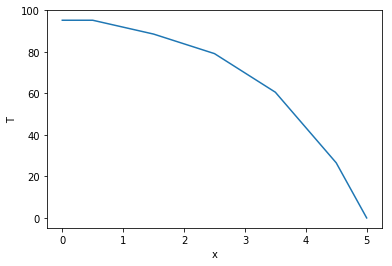

[0.  0.5 1.5 2.5 3.5 4.5 5. ]


In [74]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(grid.xP, T)
TQUICK = T
plt.xlabel("x")
plt.ylabel("T")
plt.show()
print(grid.xP)

# <center><font color=|blue|>Analytical Solution</font></center>

The properties of water are $\rho$ = 1000 [kg/m$^3$], $k$ = 0.590 [W/m$\cdot$K], and $c_p$ = 4189 [J/kg$\cdot$K]. The exact solution for this problem is:

$$
    \frac{T_{\infty}-T(x)}{T_{\infty}-T_{in}}= e^{-\frac{h P_o x}{\dot{m} c_p}}
$$

To solve this problem, start with 5 equal-length control volumes, initialize the temperature and velocity fields as $T$ = 0 [K] and $u$ = 1.5 [m/s], and use a time-step size of $10^{10}$ [s]. 

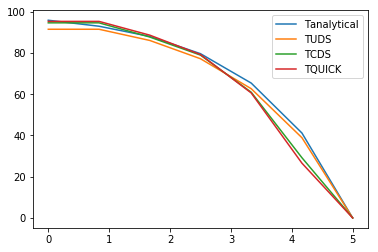

[95.85364041 92.95216379 88.02033587 79.63738821 65.3883486  41.16833216
  0.        ]
[91.48267162 91.48267162 86.06064404 77.18701918 62.6645524  38.89725951
  0.        ]
[94.5965859  94.5965859  87.71806887 78.95212301 60.94381808 29.18998365
  0.        ]
[95.29994026 95.29994026 88.62912315 79.2113502  60.60101306 26.55427184
  0.        ]


In [75]:
%matplotlib inline
import numpy as np
import matplotlib
x = np.linspace(0,5,7)
rho = 1000
Po = 4*.01
Tinf = 100
Tin = 0
ho = 10000
cp  = 4189
mdot = (rho * .01*.01* 1.5)
Tana = Tinf-((Tinf-Tin)*np.exp((-ho*Po*x)/(mdot*cp)))
Tana = np.flip(Tana,0)

import matplotlib.pyplot as plt
plt.plot(x, Tana , '-', label='Tanalytical')
plt.plot(x, TUDS , '-', label='TUDS')
plt.plot(x, TCDS , '-', label='TCDS')
plt.plot(x, TQUICK , '-', label='TQUICK')
plt.legend()
plt.show()
print (Tana)
print (TUDS)
print (TCDS)
print (TQUICK)